Projet 1:

Etape 1

In [3]:
import spacy
import json

# Charger le modèle SpaCy
nlp = spacy.load("en_core_web_sm")

# Charger les données
def load_jsonl(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return [json.loads(line) for line in file]

# Charger les avis
reviews = load_jsonl("reviews.jsonl")
documents = [review["title"] + " " + review["text"] for review in reviews]

# Prétraitement
processed_reviews = []
for doc in nlp.pipe(documents, disable=["ner", "parser"]):
    tokens = [token.lemma_ for token in doc 
              if not token.is_stop 
              and not token.is_punct 
              and not token.is_digit 
              and len(token) > 1]
    processed_reviews.append(tokens)

# Sauvegarde des données nettoyées
with open("processed_reviews.json", "w", encoding="utf-8") as file:
    json.dump(processed_reviews, file, ensure_ascii=False, indent=2)

print("Données préparées et sauvegardées dans 'processed_reviews.json'")


Données préparées et sauvegardées dans 'processed_reviews.json'


Etape 2

In [ ]:
import json

# Charger le fichier JSON contenant les tokens pré-traités
with open("processed_reviews.json", "r", encoding="utf-8") as file:
    documents = json.load(file)

# Combinez les tokens pour chaque document en une seule chaîne
text_documents = [" ".join(tokens) for tokens in documents]


In [5]:
from sentence_transformers import SentenceTransformer

# Charger le modèle SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Générer les embeddings pour chaque document
embeddings = model.encode(text_documents, show_progress_bar=True)


Batches: 100%|██████████| 32/32 [00:03<00:00,  8.11it/s]


In [ ]:
from sklearn.cluster import KMeans

# Définition du nombre de clusters
num_clusters = 5

# Appliquer KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)


In [ ]:
from collections import defaultdict

# Association des documents aux clusters
clusters = defaultdict(list)
for doc, label in zip(text_documents, cluster_labels):
    clusters[label].append(doc)


In [ ]:
from collections import Counter

# Calcul des fréquences des mots pour chaque cluster
for cluster, docs in clusters.items():
    if cluster == -1:  
        continue
    word_counter = Counter(" ".join(docs).split())
    print(f"Cluster {cluster}:")
    print(word_counter.most_common(10))


Cluster 2:
[('work', 119), ('phone', 102), ('great', 71), ('screen', 65), ('good', 48), ('product', 41), ('use', 40), ('time', 36), ('easy', 33), ('like', 29)]
Cluster 0:
[('great', 95), ('band', 80), ('fit', 70), ('love', 70), ('like', 69), ('look', 59), ('phone', 50), ('watch', 48), ('good', 47), ('easy', 46)]
Cluster 1:
[('case', 661), ('phone', 578), ('great', 170), ('fit', 156), ('good', 141), ('screen', 124), ('like', 112), ('love', 110), ('cover', 103), ('look', 98)]
Cluster 3:
[('charge', 198), ('charger', 119), ('work', 110), ('phone', 99), ('cable', 71), ('great', 64), ('time', 56), ('need', 55), ('good', 51), ('use', 51)]
Cluster 4:
[('star', 17), ('Stars', 17), ('love', 8), ('great', 7), ('perfect', 5), ('case', 4), ('beautiful', 4), ('color', 4), ('phone', 4), ('Star', 3)]


In [ ]:
from sklearn.metrics import silhouette_score

# Calcul du Silhouette Score
if len(set(cluster_labels)) > 1:
    score = silhouette_score(embeddings, cluster_labels)
    print(f"Silhouette Score: {score}")
else:
    print("Impossible de calculer le Silhouette Score : un seul cluster détecté.")


Silhouette Score: 0.06073302403092384


c:\Users\abygu\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


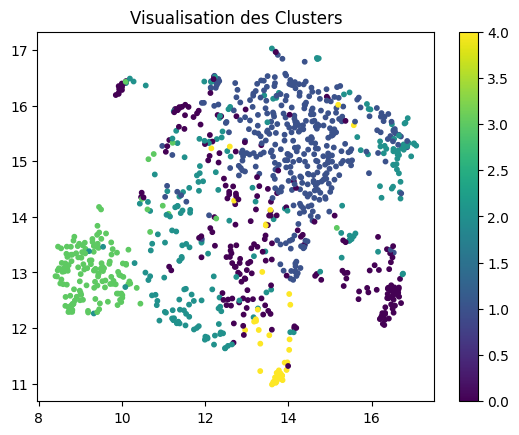

In [10]:
import umap
import matplotlib.pyplot as plt

# Réduction de dimension avec UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Visualisation des clusters
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=cluster_labels, cmap='viridis', s=10)
plt.colorbar()
plt.title("Visualisation des Clusters")
plt.show()


Etape 3

In [ ]:
import json

# Charger les avis et les notes réelles
with open("reviews.jsonl", "r", encoding="utf-8") as file:
    reviews = [json.loads(line) for line in file]

# Extraction des textes des avis et les notes réelles (ratings)
texts = [review["text"] for review in reviews]
ratings = [review["rating"] for review in reviews]


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Chargement du modèle et du tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


c:\Users\abygu\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\abygu\.cache\huggingface\hub\models--nlptown--bert-base-multilingual-uncased-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [ ]:
from torch.utils.data import DataLoader, Dataset
import torch

# Création d'une classe Dataset pour les avis
class ReviewsDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx]

# Configuration du DataLoader
batch_size = 16
dataset = ReviewsDataset(texts)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


In [14]:
from torch.nn.functional import softmax

# Activer le mode évaluation
model.eval()

predictions = []

with torch.no_grad():
    for batch in dataloader:
        # Tokenisation
        tokens = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
        
        # Passage dans le modèle
        outputs = model(**tokens)
        
        # Appliquer Softmax pour obtenir les probabilités
        probs = softmax(outputs.logits, dim=1)
        
        # Prédiction (classe avec la probabilité maximale)
        batch_predictions = torch.argmax(probs, dim=1) + 1  # +1 pour correspondre aux classes 1-5
        predictions.extend(batch_predictions.cpu().numpy())


In [15]:
from scipy.stats import pearsonr

# Calcul de la corrélation entre les notes réelles et prédites
correlation, _ = pearsonr(ratings, predictions)
print(f"Corrélation de Pearson : {correlation:.2f}")


Corrélation de Pearson : 0.82


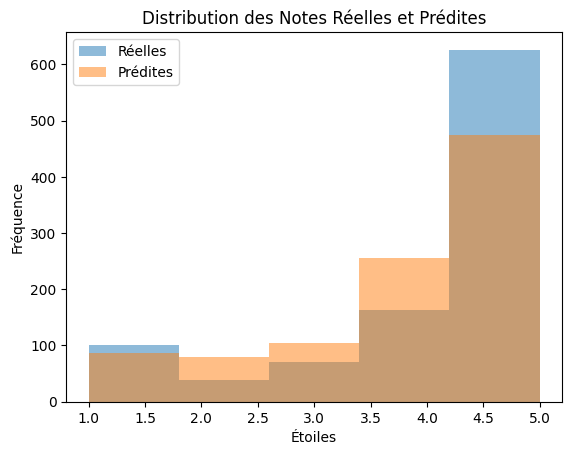

In [16]:
import matplotlib.pyplot as plt

# Distribution des notes réelles
plt.hist(ratings, bins=5, alpha=0.5, label="Réelles")
# Distribution des prédictions
plt.hist(predictions, bins=5, alpha=0.5, label="Prédites")

plt.legend()
plt.title("Distribution des Notes Réelles et Prédites")
plt.xlabel("Étoiles")
plt.ylabel("Fréquence")
plt.show()
